## Neural Nets Implementation & XOR Problem

**Goal:** The goal of this exercise is to implement a small neural network from scratch and train it using backprop.

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [3]:
# Load xor toy dataset
with open('xordata.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train'] # 800 training data points with 2 features
y_train = data['y_train'] # training binary labels {0,1}

X_test = data['X_test']
y_test = data['y_test']

In [4]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 2) (800,)
(200, 2) (200,)


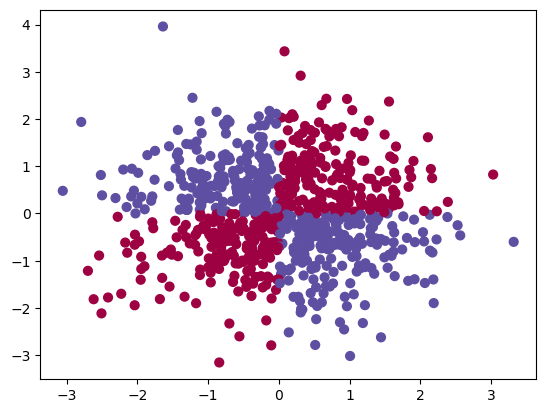

In [5]:
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)

**In this exercise, do the following:**
1. Implement brackprop to train a two-layer perceptron: an input layer, a hidden layer, and an output layer.
2. The core of the code should include: a forward pass, a backward pass, and weight updates.
3. For input and output layers specify the number of nodes appropriate for the above problem.
4. Randomly initialize the weights and biases of the network.
5. For the hidden layer use ReLU as an activation function and for the output layer use logistic sigmoid.
6. Use cross-entropy loss as the network's loss function and mini-batch SGD as the optimizer.
7. Use cross-validation to estimate performance.
8. Tune the network as you see fit (including number of units in the hidden layer, learning rate,  batch size, number of epochs, etc).
9. Provide a classification report of the performance on the train and test set.
10. Write a summary. Make sure you document your code well.
  
(Optional) You can use sklearn.inspection.DecisionBoundaryDisplay to visualize your decision boundary.

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import abc
from tqdm import tqdm

In [148]:
def one_hot_encode(y, n_classes):
    return np.identity(n_classes)[y.astype(int)]


def generate_data(dataset_name, n_samples=100):
    match dataset_name:
        case 'regression: an affine line':
            X = np.random.uniform(-5, 5, size=(n_samples, 1))
            y = 3 * X - 100
        case 'regression: cubic polynomial':
            X = np.random.uniform(-5, 5, size=(n_samples, 1))
            y = X ** 3 - 2 * X + 5
        case 'classification: linearly separable':
            X = np.random.normal(size=(n_samples, 2))
            y = one_hot_encode((X[:, 0] > X[:, 1] + 1).astype(int), 2)
        case 'classification: XOR':
            X = np.random.normal(size=(n_samples, 2))
            y = one_hot_encode((X[:, 0] * X[:, 1] > 0).astype(int), 2)
        case _:
            raise ValueError('invalid dataset name')
    return X, y


# 
def train_and_test(model, loss_fn, optimizer, dataset_name, n_epochs=5000, n_samples=100):
    # train
    X_train, y_train = generate_data(dataset_name, n_samples=n_samples)
    losses = []
    for _ in tqdm(range(n_epochs)):
        output = model.forward(X_train)
        loss = loss_fn.forward(output, y_train) 
        losses.append(loss)
        model.backward(loss_fn.backward())
        optimizer.step()

    # test and plot
    X_test, y_test = generate_data(dataset_name, n_samples=n_samples)
    fig, ax = plt.subplots(ncols=2)
    fig.set_size_inches(10, 5)
    ax[0].set_title('loss during training')
    ax[1].set_title('predictions and truth')
    if dataset_name.startswith('classification'):
        y_pred = np.argmax(model.forward(X_test), axis=1)
        sns.lineplot(losses, ax=ax[0])
        sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=np.argmax(y_test, axis=1), ax=ax[1])
        sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, s=100, alpha=0.2, ax=ax[1])
        plt.legend([],[],frameon = False)
    elif dataset_name.startswith('regression'):
        y_pred = model.forward(X_test)
        sns.lineplot(losses, ax=ax[0])
        sns.scatterplot(x=X_test[:, 0], y=y_test[:, 0], ax=ax[1])
        sns.scatterplot(x=X_test[:, 0], y=y_pred[:, 0], s=100, alpha=0.2, ax=ax[1])
        # for prediction data, make size bigger and alpha 0.2 
        plt.legend([],[], frameon=False)
        # frameon is for deleting the box surrounding the legend.

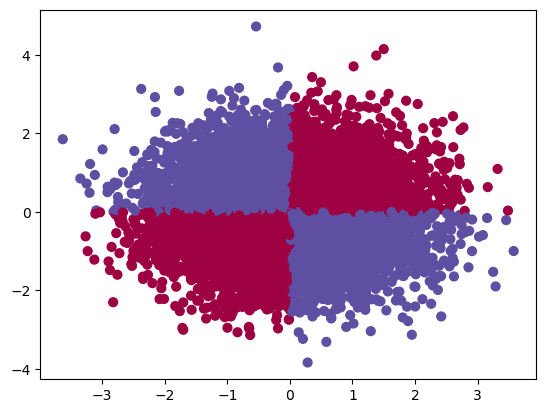

In [150]:
x,y = generate_data("classification: XOR",10000)
y1d = y[:,0]==1
plt.scatter(x[:,0], x[:,1], s=40, c=y1d, cmap=plt.cm.Spectral)


In [9]:
class Module:
    # require inheriting classes to implement the abstract methods
    __metaclass__ = abc.ABCMeta 

    def __init__(self, name):
        '''
        Stores learnable weights in a dictionary `self.weights` keyed by
        strings.
        '''
        
        self.name = name
        self.weights = {}
        self.grad_weights = {}

    @abc.abstractmethod
    def forward(self, input):
        '''
        Computes the output of the module, then stores the output in
        `self.output` and returns it.
        '''
        pass

    @abc.abstractmethod
    def backward(self, grad_output):
        '''
        Computes `self.grad_weights` organized as a dictionary in the same
        way as `self.weights` and returns `grad_input`.
        '''
        pass

    def __repr__(self):
        return self.name


class Composition(Module): # in PyTorch this is called `Sequential`
    
    def __init__(self, submodules):
        self.submodules = submodules
        
        self.name =  f'Composition ({", ".join(submodule.name for submodule in submodules)})'
        
        self.weights = {
            f'{submodule.name}.{weight_name}':weight
            for submodule in self.submodules
            for weight_name, weight in submodule.weights.items()
        }
                
    def forward(self,input):
        for submodule in self.submodules:
            input = submodule.forward(input)
        self.output = input
        return input

    def backward(self, grad_output):
        for submodule in reversed(self.submodules):
            grad_output = submodule.backward(grad_output)

        self.grad_weights = {
            f"{submodule.name}.{weight_name}" : grad_weight
            for submodule in self.submodules
            for weight_name, grad_weight in submodule.grad_weights.items()
        }
        return grad_output
    

class SGD:

    def __init__(self, module, lr=1e-3):
        self.module = module
        self.lr = lr

    def step(self):
        for weight_name, weight in self.module.weights.items():
            weight -= self.lr * self.module.grad_weights[weight_name]
   

In [10]:
class MSE(Module):
    def __init__(self):
        super().__init__('MSE')

    def forward(self, input_y, input_t):
        self.input_y = input_y
        self.input_t = input_t
        return np.mean((input_y - input_t)**2)

    def backward(self):
        return 2 * (self.input_y - self.input_t )/ len(self.input_t)

In [11]:
class Linear(Module):

    def __init__(self, n_in_features, n_out_features):
        super().__init__(f'Linear({n_in_features}, {n_out_features})')
        self.n_in_features = n_in_features
        self.n_out_features = n_out_features
        
        # Initialize weights so that they are uniformly in the unit ball. Don't
        # worry about this choice; for examples of other choices, see
        # https://pytorch.org/docs/stable/nn.init.html
        stdv = 1.0 / np.sqrt(self.n_in_features)
        sample_unit_ball = lambda size: np.random.uniform(-stdv, stdv, size)
        self.weights = {
            'W': sample_unit_ball((n_out_features, n_in_features)),
            'b': sample_unit_ball((n_out_features, ))
        }

    def forward(self, input):
        self.input = input
        return input @ self.weights['W'].T + self.weights['b']

    def backward(self, grad_output):
        self.grad_weights = {
            'W': grad_output.T @ self.input,
            'b': grad_output.T @ np.ones((len(self.input), ))
        }
        grad_linear = self.weights['W']
        return grad_output @ grad_linear

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 8851.36it/s]


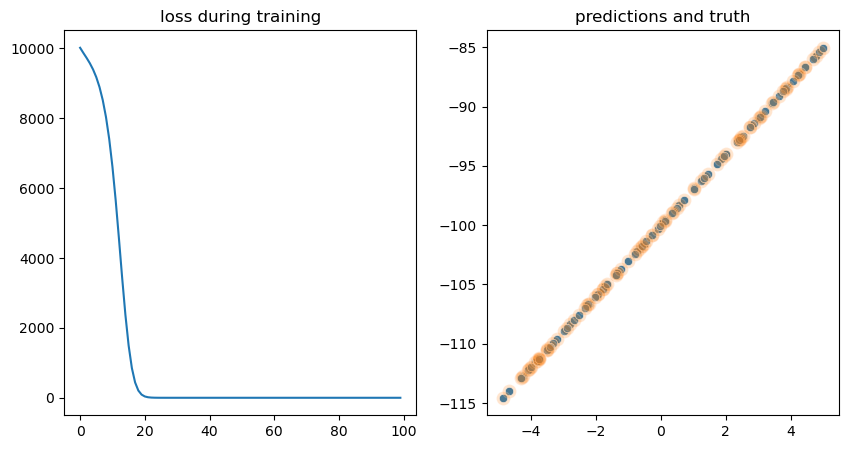

In [128]:
model = Composition([
    Linear(1, 8),
    Linear(8, 1)
])

train_and_test(
    model=model,
    loss_fn=MSE(),
    optimizer=SGD(model, lr=1e-3),
    dataset_name='regression: an affine line',
    n_epochs=100,
    n_samples=100
)

In [13]:
class Softmax(Module):

    def __init__(self, n_classes):
        super().__init__(f'Softmax({n_classes})')
        self.n_classes = n_classes

    def forward(self, input):
        p = np.exp(input)
        sums = np.sum(p, axis = 1)
        self.output = (p.T / sums.T).T
        return self.output
    
    def backward(self, grad_output):
        # hacks :)
        s = self.output
        diag = np.einsum('ij, jk -> ijk', s, np.identity(s.shape[1]))
        outer = np.einsum('ij, ik -> ijk', s, s)
        grad_softmax = diag - outer
        return np.einsum('ijk, ik -> ij', grad_softmax, grad_output)


class ReLU(Module):

    def __init__(self):
        super().__init__('ReLU')

    def forward(self, input):
        self.input = input
        return input *(input > 0) 
    
    def backward(self, grad_output):
        grad_relu = (self.input > 0)
        return grad_output * grad_relu

100%|████████████████████████████████████| 5000/5000 [00:00<00:00, 13702.24it/s]


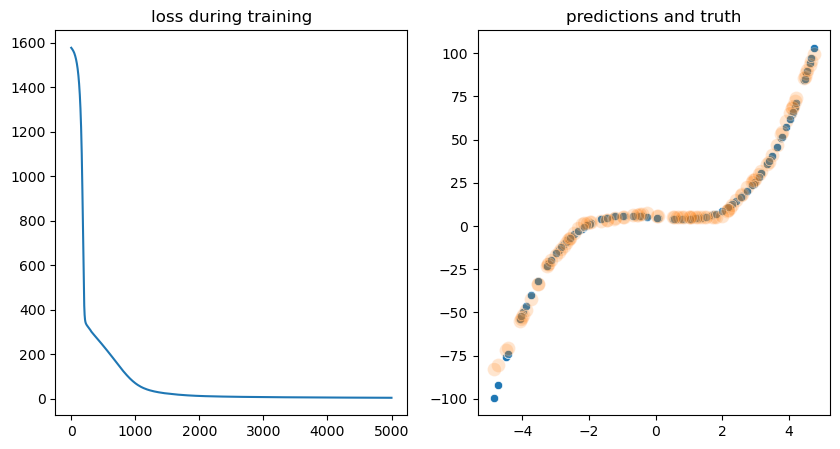

In [14]:
model = Composition([
    Linear(1, 8),
    ReLU(),
    Linear(8, 8),
    ReLU(),
    Linear(8, 1),
])

train_and_test(
    model,
    MSE(),
    SGD(model, lr=1e-4),
    'regression: cubic polynomial',
    n_epochs=5000,
    n_samples=100
)

In [15]:
class SoftmaxCrossEntropy(Module):

    def __init__(self, n_classes):
        super().__init__(f'CrossEntropy({n_classes})')
        self.n_classes = n_classes
        self.softmax = Softmax(n_classes)

    def forward(self, input, t):
        self.t = t
        self.softmax_output = self.softmax.forward(input)
        return -np.mean(t*np.log(self.softmax_output + 1e-6))
    
    def backward(self):
        return (self.softmax_output - self.t) / len(self.t)

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 14618.17it/s]


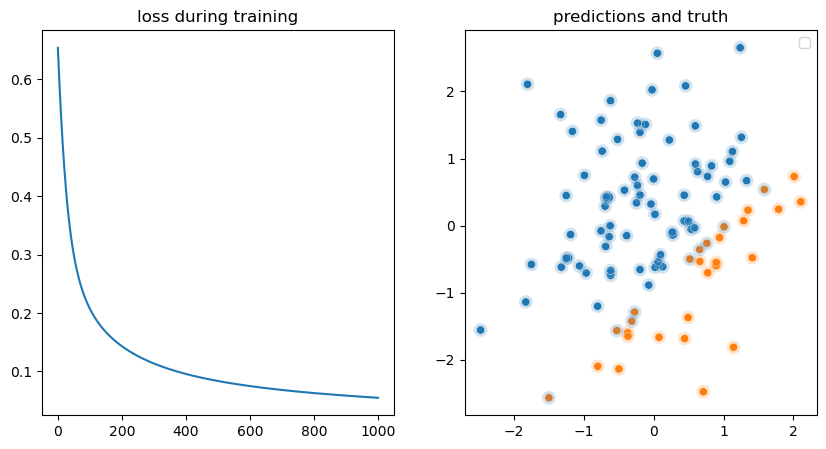

In [132]:
model = Composition([
    Linear(2, 8),
    Linear(8, 2),
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: linearly separable',
    n_epochs=1000,
    n_samples=100
)

100%|█████████████████████████████████████| 5000/5000 [00:01<00:00, 4254.52it/s]


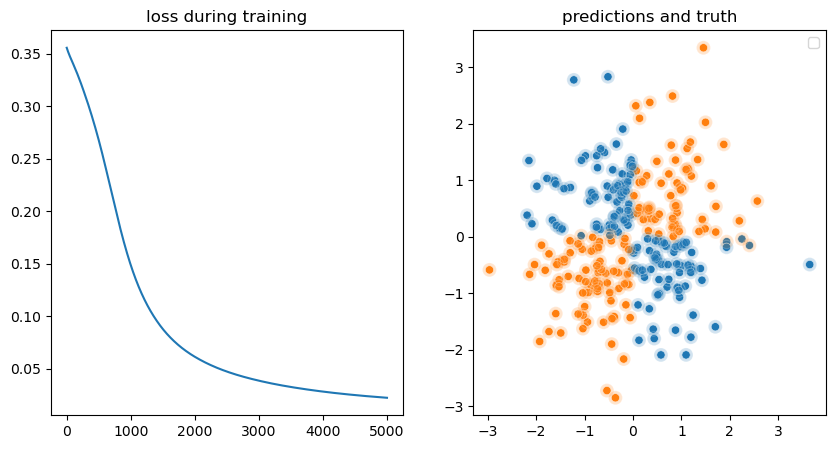

In [134]:
H = 32

model = Composition([
    Linear(2, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, 2)
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: XOR',
    n_epochs=5000,
    n_samples=250
)

In [18]:
# the model above might be the best but it has two hidden layer 

100%|█████████████████████████████████████| 5000/5000 [00:00<00:00, 8618.21it/s]


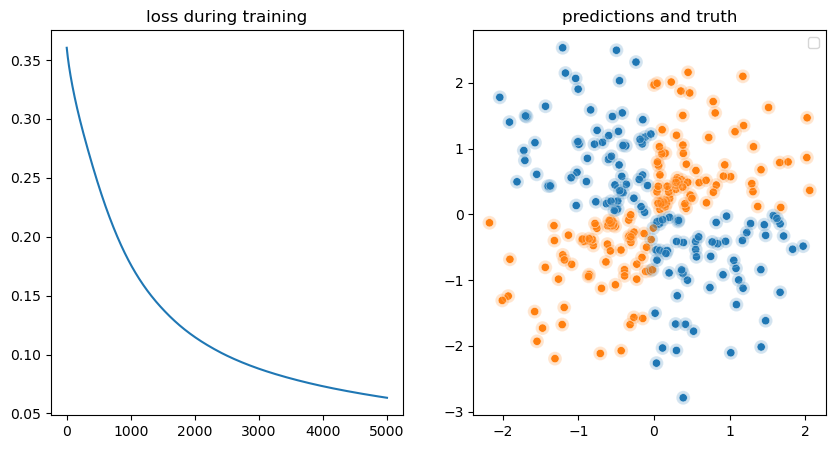

In [136]:
H = 32
model = Composition([
    Linear(2,H),
    ReLU(),
    Linear(H,2)
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr = 1e-2),
    "classification: XOR",
    n_epochs = 5000,
    n_samples = 250
)

In [20]:
from sklearn.metrics import classification_report

In [21]:
ts_pred = np.argmax(model.forward(X_test), axis=1)
tr_pred = np.argmax(model.forward(X_train), axis=1)

In [22]:
class metrics:
    def __init__(self, t,p):
        self.tp = np.sum((p==1)&(t==1))
        self.fp = np.sum((p==1)&(t==0))
        self.tn = np.sum((p==0)&(t==0))
        self.fn = np.sum((p==0)&(t==1))
        self.pre = 0
        self.re = 0
        self.f1 = 0

    def precision(self):
        print("precision")
        self.pre = self.tp / (self.tp + self.fp)
        print(self.pre)
        
    def recall(self):
        print("recall")
        self.re = self.tp / (self.tp + self.fn)
        print(self.re)

    def F1_score(self):
        print("F1_score")
        if(self.pre + self.re == 0.0):
            print("0 division")
            return 
        self.f1 =  2 * (self.pre * self.re)/(self.pre + self.re) 
        print(self.f1)
        
    def all(self):
        self.precision()
        self.recall()
        self.F1_score()

In [23]:
# classificaton report for train data.
classification_report(y_train,tr_pred)

'              precision    recall  f1-score   support\n\n           0       0.03      0.03      0.03       387\n           1       0.03      0.02      0.03       413\n\n    accuracy                           0.03       800\n   macro avg       0.03      0.03      0.03       800\nweighted avg       0.03      0.03      0.03       800\n'

In [24]:
metrics(y_train, tr_pred).all()

precision
0.026041666666666668
recall
0.024213075060532687
F1_score
0.02509410288582183


In [25]:
# classification report for test data.
classification_report(y_test,ts_pred)

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00      97.0\n           1       0.00      0.00      0.00     103.0\n\n    accuracy                           0.00     200.0\n   macro avg       0.00      0.00      0.00     200.0\nweighted avg       0.00      0.00      0.00     200.0\n'

In [26]:
metrics(y_test,ts_pred).all()

precision
0.0
recall
0.0
F1_score
0 division


# summary 
actually, I follow or just used TA's code other than metrics class.
I was creating the nn class which has everything from init to forward pass, backward pass, activatin function, loss function etc..
but like TA said, it is hard to debug it.

TA's code is meant to call model that has each component in neural network sucha as layer and activation function.
and when calling train function, you can pass loss function. 
